In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy.interpolate import griddata
from scipy.spatial import Delaunay

from utils.data import (load_data, bonds, bond_to_float, calculate_moments,
                        plot_cevr, plot_pca, plot_profiles, plot_crystal_graph)
from utils.model import load, prepare_data, train_models, plot_scores, predict

seed = 12

In [3]:
# load data
dirname = 'data/'
data = load_data(dirname, structure=True, labeled=False, sort=True)

EVR of 0.99 at 6 components


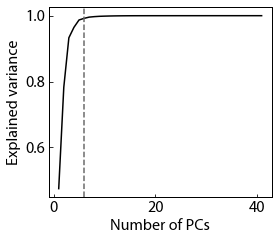

In [4]:
# compute and plot PCA summary
X = np.stack(data['elf'].sum())
n_components = X.shape[-1]
pca = PCA(n_components=n_components, svd_solver='full')
z = pca.fit_transform(X)

# plot cumulative explained variance
plot_cevr(pca.explained_variance_ratio_, save_path=None)

In [5]:
# calculate moments
data = calculate_moments(data)

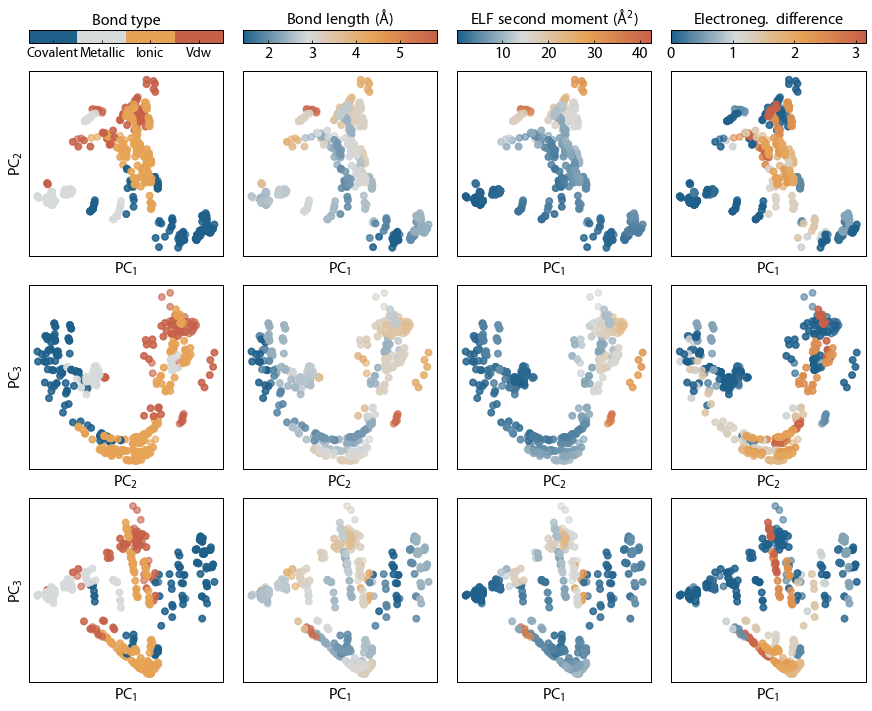

In [6]:
# plot PC projections
plot_pca(z, data, bonds, axes=[0,1,2], save_path=None)

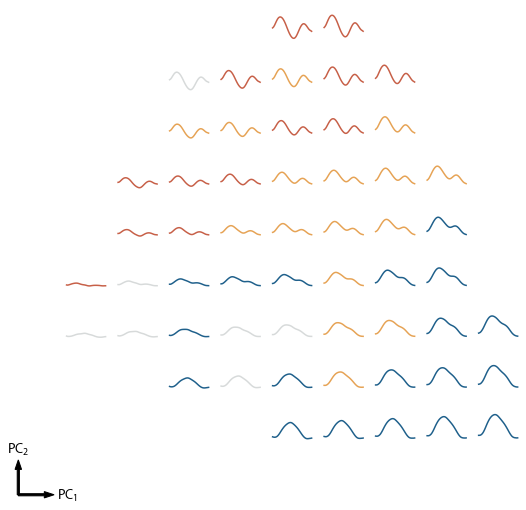

In [7]:
# plot profiles along principal axes
plot_profiles(z, data, pca, colorby='label', axes=[0,1], save_path=None)

100%|██████████| 100/100 [04:21<00:00,  2.61s/it]                               


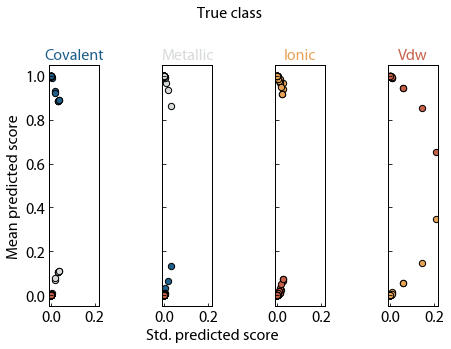

In [8]:
# train or load model
fit = False
model_path = 'models/clfs_042622'
n_components = 7
test_size = 0.15
n_models = 100

if fit:
    # train models
    X_data, y_data, pca, scaler = prepare_data(data, n_components, test_size, seed=seed, pca=None, scaler=None)
    CLFs = train_models(X_data, y_data, pca, scaler, n_models=n_models, seed=seed, save_path=model_path)
    
    # plot model performance on held-out test set
    y_pred_mean = np.stack([CLFs['clfs'][i].predict_proba(X_data[1]) for i in range(n_models)]).mean(axis=0)
    y_pred_std = np.stack([CLFs['clfs'][i].predict_proba(X_data[1]) for i in range(n_models)]).std(axis=0)
    plot_scores(y_pred_mean, y_pred_std, y_data[1], save_path=None)

else:
    # load models
    CLFs = load(model_path + '.joblib')

In [9]:
# make predictions and optionally save output dataframe
data = predict(data, CLFs, save_path=None)

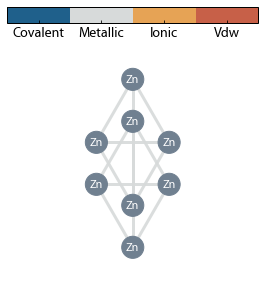

In [19]:
# plot crystal graph with edges colored by predicted bond type
plot_crystal_graph(data, index=40, save_path=None)